In [4]:
!pip install -U keras
!pip install -U tensorflow

You should consider upgrading via the 'c:\users\losh\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


Using legacy setup.py install for termcolor, since package 'wheel' is not installed.
    Running setup.py install for termcolor: started
    Running setup.py install for termcolor: finished with status 'done'


You should consider upgrading via the 'c:\users\losh\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [6]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
# from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [7]:
#5 mil reviews
import csv
import pandas as pd
df_review_csv = pd.read_csv('D:\Ryerson\CIND820\Kaggle_yelp_dataset_CSV\yelp_review.csv')

In [8]:
#170k businesses
import csv
import pandas as pd
df_business_csv = pd.read_csv('D:\Ryerson\CIND820\Kaggle_yelp_dataset_CSV\yelp_business.csv')

In [9]:
a = df_business_csv[df_business_csv['categories'].str.contains('Restaurant') == True]
rev = df_review_csv[df_review_csv.business_id.isin(a['business_id']) == True]

In [10]:
rev_samp = rev.sample(n = 350000, random_state = 42)
train = rev_samp[0:280000]
test = rev_samp[280000:]

In [11]:
train.shape, test.shape

((280000, 9), (70000, 9))

,text,stars
2760442,Second time here.... first time had the pulled...,5
3014452,Great place. Like their sauce and lunch specia...,5
2876979,So goooooooood and so simple! I love their pel...,5
469097,We stopped in for a late lunch on a Tuesday af...,3
4971248,A great option to try hakka chinese since its ...,4


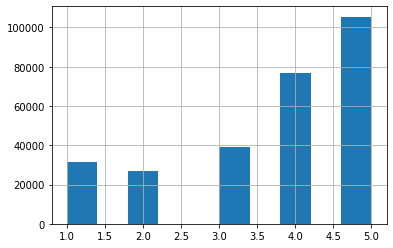

In [12]:
#train = pd.read_csv('/home/adam/R/Yelp/dataset/model_train.csv', usecols = ['text', 'stars'])
train = train[['text', 'stars']]
train['stars'].hist();train.head()

In [13]:
train = pd.get_dummies(train, columns = ['stars'])
train.head()

,text,stars_1,stars_2,stars_3,stars_4,stars_5
2760442,Second time here.... first time had the pulled...,0,0,0,0,1
3014452,Great place. Like their sauce and lunch specia...,0,0,0,0,1
2876979,So goooooooood and so simple! I love their pel...,0,0,0,0,1
469097,We stopped in for a late lunch on a Tuesday af...,0,0,1,0,0
4971248,A great option to try hakka chinese since its ...,0,0,0,1,0


In [14]:
#test = pd.read_csv('/home/adam/R/Yelp/dataset/model_test.csv', usecols=['text', 'stars'])
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns = ['stars'])
train.shape, test.shape

((280000, 6), (70000, 6))

In [15]:
# set frac = 1. to use the entire sample
train_samp = train.sample(frac = .1, random_state = 42)
test_samp = test.sample(frac = .1, random_state = 42)
train_samp.shape, test_samp.shape

((28000, 6), (7000, 6))

In [16]:
# max_features is an upper bound on the number of words in the vocabulary
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

In [17]:
class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [18]:
# Create pipeline using sklearn pipeline:
    # I basically create my tfidf features which are fed to my NB model 
    # for probability calculations. Then those are fed as input to my 
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [19]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []
preds = np.zeros((len(test_samp), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train_samp[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train_samp['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train_samp['text'].values, train_target)
    preds[:,i] = p.predict_proba(test_samp['text'].values)[:,1]

CV score for class stars_1 is 0.9282499819604656
CV score for class stars_2 is 0.90339283521352
CV score for class stars_3 is 0.8591786654537303
CV score for class stars_4 is 0.7321071676830603
CV score for class stars_5 is 0.8044644727087923


In [20]:
t = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       771
           1       0.43      0.15      0.23       687
           2       0.49      0.31      0.38      1020
           3       0.47      0.46      0.47      1906
           4       0.67      0.85      0.75      2616

    accuracy                           0.59      7000
   macro avg       0.54      0.50      0.50      7000
weighted avg       0.56      0.59      0.56      7000

